In [1]:
import os
import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt
import pickle
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_VER31_R_consolidated_condensed.csv')
edges = pd.read_csv('../data/edges_VER31_R_consolidated_condensed.csv')

# remove : character from column names to make them queryable
nodes = gt.remove_colons(nodes)
edges = gt.remove_colons(edges)

In [3]:
comps = (nodes['label'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['label'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

79,223 Compounds x 34,325 Diseases = 2,719,329,475 C-D pairs


In [4]:
nodes.head(2)

,id,name,label,id_source
0,C0418940,Change of employment,Activities & Behaviors,UMLS
1,D006686,Hobbies,Activities & Behaviors,MeSH


In [5]:
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,C0441648,D014838,ADMINISTERED_TO_ABatLB,{18423504},1
1,C0441648,D002648,ADMINISTERED_TO_ABatLB,"{28507890, 15608027, 29402495}",3


In [6]:
counts = edges["type"].value_counts()
counts.head(20)

LOCATION_OF_AloCD         976627
REGULATES_CDreg>CD        822256
INTERACTS_WITH_CDiwG      685425
LOCATION_OF_AloG          530568
TREATS_CDtDO              523202
ASSOCIATED_WITH_DOawDO    465285
LOCATION_OF_AloDO         458458
PRODUCES_LBpdCD           454085
AFFECTS_DOafLB            429212
STIMULATES_CDstG          377490
TREATS_PRtDO              345634
AFFECTS_CDafA             317921
ASSOCIATED_WITH_GawDO     259812
AFFECTS_GafPS             250153
USES_PRuCD                249391
INHIBITS_GinCD            241332
LOCATION_OF_AloA          227011
AUGMENTS_CDagPS           226235
PART_OF_GpoLB             216165
INTERACTS_WITH_GiwG       204609
Name: type, dtype: int64

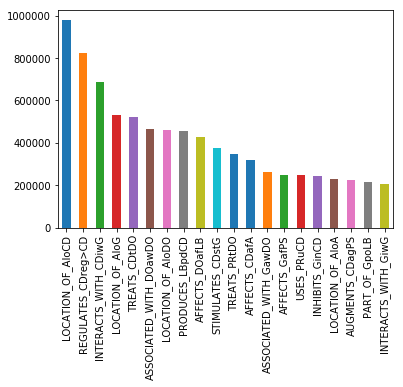

In [7]:
counts[:20].plot(kind='bar');

# Filter out the lower count edge types

In [8]:
'{:,}'.format(edges.shape[0])

'12,270,779'

In [9]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 70
Number of edges that remain with this cutoff: 11,458,208


In [10]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [11]:
result = edges.query('type in @ok_edges')

In [12]:
'{:,}'.format(result.shape[0])

'11,458,208'

# Some quick validation that all ids are the same between nodes and edges

In [13]:
edge_ids = set(result['start_id'].unique()).union(set(result['end_id'].unique()))

In [14]:
node_ids = set(nodes['id'].unique())

In [15]:
not_in_edges = node_ids - edge_ids

In [16]:
not_in_edges = list(not_in_edges)

In [17]:
idx = nodes.query('id in @not_in_edges').index
nodes = nodes.drop(idx)

In [18]:
len(nodes)

215648

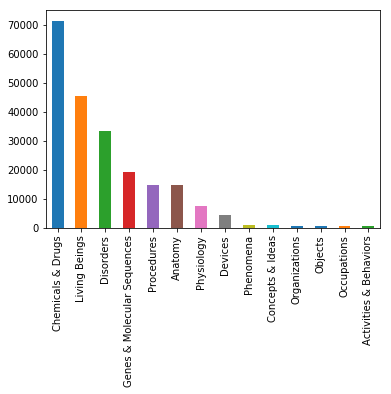

In [19]:
nodes['label'].value_counts().plot(kind='bar');

# Look at the resulting network to see if other changes are necessary

In [20]:
combo = gt.combine_nodes_and_edges(gt.add_colons(nodes), gt.add_colons(result[['start_id', 'end_id', 'type', 'n_pmids']]))
combo = gt.remove_colons(combo)

In [21]:
combo.head(2)

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
446,D020927,C0682053,ADMINISTERED_TO_CDatLB,1,Dexmedetomidine,Toddler,Chemicals & Drugs,Living Beings
447,D019695,D014838,ADMINISTERED_TO_CDatLB,2,Glycyrrhizic Acid,Volunteers,Chemicals & Drugs,Living Beings


In [22]:
max_edge = combo["n_pmids"].max()
combo.query('n_pmids == @max_edge')

,start_id,end_id,type,n_pmids,start_name,end_name,start_label,end_label
1933955,DOID:5559,DOID:5559,ASSOCIATED_WITH_DOawDO,68380,mediastinal cancer,mediastinal cancer,Disorders,Disorders


In [23]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = combo.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

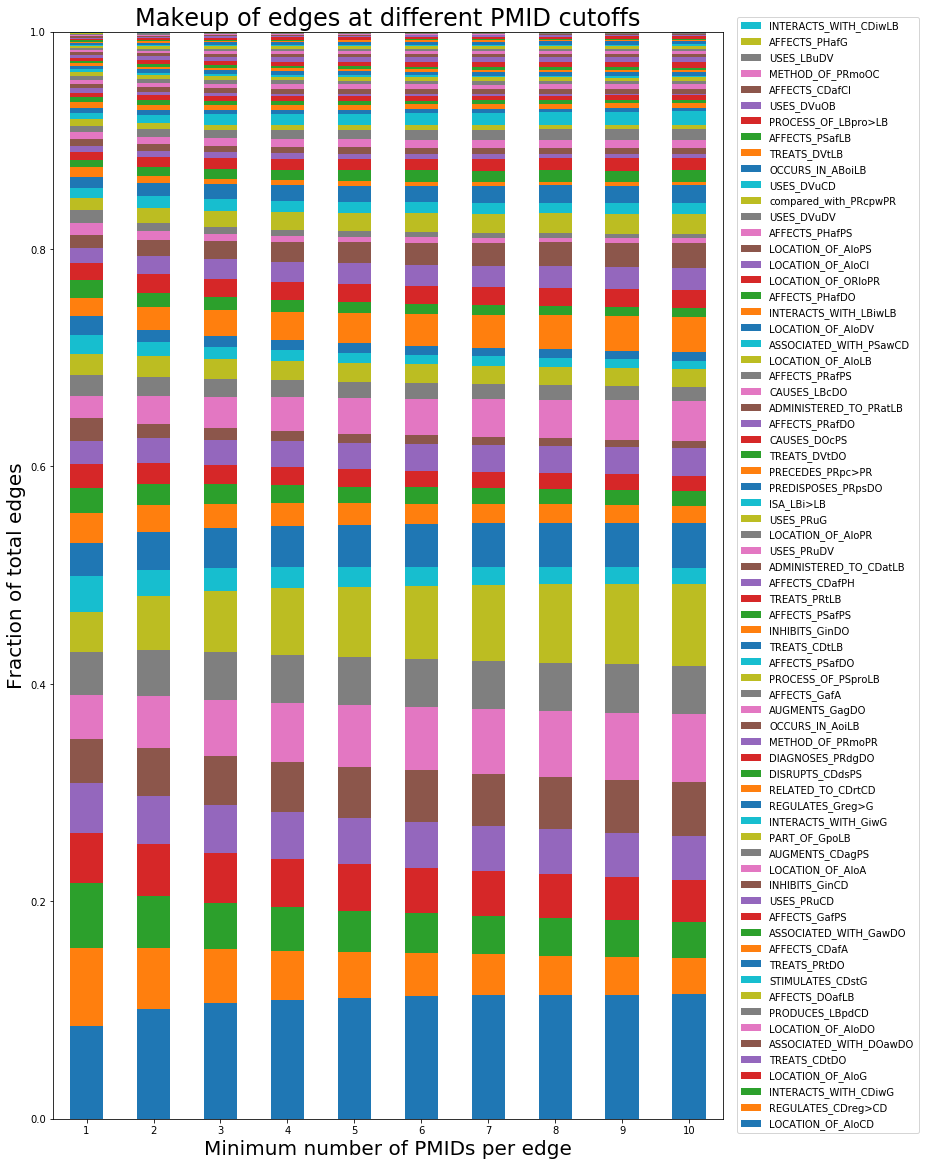

In [24]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [25]:
combo.sort_values('n_pmids', ascending=False)[['n_pmids', 'start_name', 'type', 'end_name']].iloc[:60]

,n_pmids,start_name,type,end_name
1933955,68380,mediastinal cancer,ASSOCIATED_WITH_DOawDO,mediastinal cancer
7880591,46560,Brain,OCCURS_IN_AoiLB,Rats
7841809,46527,Liver,OCCURS_IN_AoiLB,Rats
832731,36514,mediastinal cancer,AFFECTS_DOafLB,Child
12056658,34650,Clinical Study,USES_PRuDV,Study models
6213576,31926,Tissues,LOCATION_OF_AloDO,mediastinal cancer
837102,27306,mediastinal cancer,AFFECTS_DOafLB,Mice
812330,26719,breast cancer,AFFECTS_DOafLB,Women
5077133,24634,Serum,LOCATION_OF_AloCD,Creatinine
5300514,22235,Plasma,LOCATION_OF_AloCD,Glucose


In [26]:
combo.query('start_id == end_id')['type'].value_counts()

RELATED_TO_CDrtCD         3757
INTERACTS_WITH_GiwG       3621
REGULATES_Greg>G          3322
compared_with_PRcpwPR     1769
ASSOCIATED_WITH_DOawDO     942
ISA_LBi>LB                 827
REGULATES_CDreg>CD         555
METHOD_OF_PRmoPR           241
INTERACTS_WITH_LBiwLB      165
LOCATION_OF_AloA           161
AFFECTS_PSafPS              83
PRECEDES_PRpc>PR            56
USES_DVuDV                  35
PROCESS_OF_LBpro>LB          3
Name: type, dtype: int64

There are some instances of self-referrential edges.  These should be removed as they are not vaild in DWPC feature extraction.

In [27]:
result = gt.remove_colons(result)
idx = result.query('start_id == end_id').index
result = result.drop(idx)

In [28]:
node_degrees = pd.concat([combo['start_name'], combo['end_name']]).value_counts()

In [29]:
node_degrees[:60]

Mice                              44586
mediastinal cancer                44346
Rats                              44077
Child                             36217
Women                             30889
Tissues                           30087
Growth                            26297
Brain                             25935
Adult                             25012
Liver                             24669
Surgical Procedures, Operative    23593
Men                               22350
Cell Line                         22096
Dogs                              21438
Apoptosis                         20391
Family                            19649
Rabbits                           18548
TNF gene                          18476
Infant                            18418
Neurons                           17984
Antibodies                        17534
Wounds and Injuries               17365
Lung                              17354
Cytoplasm                         17230
DNA                               17101


Even though in a previous notebook, some of the General terms were filtered out... there are still plenty of terms that appear to be too general to be useful.  From the top 100 of these, we will filter many of them out.

In [30]:
#These are from the 100 most common nodes, removing things that are too general to be useful

too_general = ['Patients', 'Cells', 'Syndrome', 'Therapeutics', 'Proteins', 'Pharmaceutical Preparations',
 'Mice', 'Human', 'Child', 'Genes', 'Woman', 'Tissues', 'Growth', 'Individual', 'Antibodies',
 'Surgical Procedures, Operative', 'Adult', 'Enzymes', 'Symptoms', 'Animals', 'Cell Line', 'Wounds and Injuries', 'Complication',
 'House mice', 'Functional disorder', 'Infant', 'Family', 'Persons', 'Male population group', 'Monoclonal Antibodies',
 'Toxic effect', 'Infection', 'DNA', 'Control Groups', 'Injection procedure', 'Ions', 'Transcription, Genetic',
 'Organ', 'TRANSCRIPTION FACTOR', 'cohort']

In [31]:
nodes.query('name in @too_general')

,id,name,label,id_source
5102,D014024,Tissues,Anatomy,MeSH
5172,C0178784,Organ,Anatomy,UMLS
5573,D002460,Cell Line,Anatomy,MeSH
5926,D002477,Cells,Anatomy,MeSH
60088,D004247,DNA,Chemicals & Drugs,MeSH
62401,D004364,Pharmaceutical Preparations,Chemicals & Drugs,MeSH
66224,D004798,Enzymes,Chemicals & Drugs,MeSH
69073,D007477,Ions,Chemicals & Drugs,MeSH
69568,D000906,Antibodies,Chemicals & Drugs,MeSH
73273,D011506,Proteins,Chemicals & Drugs,MeSH


In [32]:
idx = nodes.query('name in @too_general').index
nodes = nodes.drop(idx).reset_index(drop=True)

In [33]:
node_ids = nodes['id'].unique()

In [34]:
result = result.query('start_id in @node_ids and end_id in @node_ids')

In [35]:
'{:,} Edges remain'.format(len(result))

'11,056,678 Edges remain'

In [36]:
counts = (result[result['n_pmids'] < 21]['n_pmids'].value_counts()
                                                   .rename('counts')
                                                   .to_frame()
                                                   .reset_index()
                                                   .rename(columns={'index':'n_pmids'}))

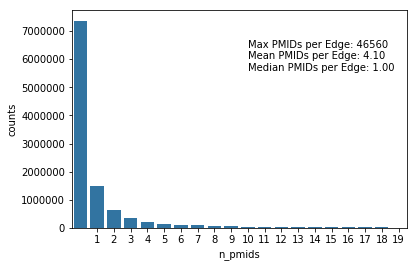

In [37]:
sns.barplot(x='n_pmids', y='counts', data=counts, color=sns.color_palette()[0])
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 0.64e7, 'Max PMIDs per Edge: {}'.format(result['n_pmids'].max()))
plt.text(10, 0.60e7, 'Mean PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].mean()))
plt.text(10, 0.56e7, 'Median PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].median()));

In [38]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (result['n_pmids'] >= i).sum()))

Edges with at least 1 unique PMIDs: 11,056,678
Edges with at least 2 unique PMIDs: 3,690,165
Edges with at least 3 unique PMIDs: 2,189,763
Edges with at least 4 unique PMIDs: 1,559,098
Edges with at least 5 unique PMIDs: 1,210,512
Edges with at least 6 unique PMIDs: 988,675
Edges with at least 7 unique PMIDs: 835,623
Edges with at least 8 unique PMIDs: 723,377
Edges with at least 9 unique PMIDs: 636,730
Edges with at least 10 unique PMIDs: 568,668


In [39]:
result = gt.add_colons(result)
nodes = gt.add_colons(nodes)

result.to_csv('../data/edges_VER31_R_consolidated_condensed_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_VER31_R_consolidated_condensed_filtered_001.csv', index=False)